In [3]:
import torch
import torch.nn as nn
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
import time, datetime, random, re
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler
from torch.cuda.amp import autocast, GradScaler
from torch.optim import AdamW
from tqdm.notebook import tqdm

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from transformers import pipeline
from operator import itemgetter
from tqdm.notebook import tqdm

import json
import pandas as pd
import numpy as np
from scipy.stats import mode
from sklearn.model_selection import train_test_split
import pickle

SEED = 15
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.cuda.amp.autocast(enabled=True)
device = torch.device("cuda")

2023-05-12 01:27:58.798792: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 01:27:59.312701: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Tokens prep

In [4]:
with open('./data/papers_merged.pickle', 'rb') as f:
    fetched_data = pickle.load(f)

physics = {'quant-ph', 'physics', 'nucl-th', 'nucl-ex', 'nlin', 
           'math-ph', 'hep-th', 'hep-ph', 'hep-lat', 'hep-ex', 
           'gr-qc', 'cond-mat', 'astro-ph', 'adap-org', 'physics'}

tags_names = {
    'cs': 'Computer Science',
    'econ': 'Economics',
    'eess': 'Electrical Engineering and Systems Science',
    'math': 'Mathematics',
    'physics': 'Physics',
    'q-bio': 'Quantitative Biology',
    'q-fin': 'Quantitative Finance',
    'stat': 'Statistics',
}

def get_cat(tag):
    # returns tag category as number / -1 if unkown
    tag = tag.split('.')[0]
    if tag in physics:
        return "physics"
    return tag

def remove_mul_spaces(text):
    return re.sub(r"\s+", " ", text)

data = pd.DataFrame([{'title': remove_mul_spaces(paper['title']),
                      'summary': remove_mul_spaces(paper['summary']),
                      'category': get_cat(paper['arxiv_primary_category']['term'])} for paper in fetched_data])

cat = pd.Categorical(data.category)
data = data\
    .drop(columns=['category'])\
    .assign(category=cat.codes)

In [5]:
cat.categories

Index(['cs', 'econ', 'eess', 'math', 'physics', 'q-bio', 'q-fin', 'stat'], dtype='object')

In [6]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

train_data, val_data = train_test_split(data, test_size=.1, stratify=data.category)

goal_num = 6_000
undesampling = {cat : min(num, 6_000) for cat, num in train_data.category.value_counts().reset_index().values}
oversampling = {cat : 6_000 for cat, _ in train_data.category.value_counts().reset_index().values}
undersampled, _ = RandomUnderSampler(sampling_strategy=undesampling).fit_resample(train_data, train_data.category)
train_data, _ = RandomOverSampler(sampling_strategy=oversampling).fit_resample(undersampled, undersampled.category)
shuffled = np.arange(len(train_data))
np.random.shuffle(shuffled)
train_data = train_data.iloc[shuffled]

MAX_LENGTH_TITLE = 30
MAX_LENGTH_SUMM = 290

def batch_encode(tokenizer, df, return_tensors='pt', batch_size=256):
    # return list of batches (input_ids, attention_mask) and list of batches of y
    title, summ = df.title.to_list(), df.summary.to_list()
    y = df.category.values
    
    encoded = []
    ys = []
    getter = itemgetter('input_ids', 'attention_mask')
    
    for i in tqdm(range(0, len(title), batch_size)):
        slice_ = slice(i, i + batch_size)
        batch_t = title[slice_]
        batch_s = summ[slice_]
        
        inputs = []
        for batch, max_length  in [(batch_t, MAX_LENGTH_TITLE), (batch_s, MAX_LENGTH_SUMM)]:
            inputs.extend(getter(tokenizer.batch_encode_plus(
                batch,
                max_length=max_length,
                padding='longest',
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=False,
                return_tensors=return_tensors
            )))
        
        encoded.append(inputs)
        ys.append(torch.nn.functional.one_hot(torch.tensor(y[slice_]).to(int), num_classes=len(cat.categories)).to(float))
    
    return encoded, ys

In [7]:
train_seq, val_seq = (batch_encode(tokenizer, df, batch_size=32) for df in [train_data, val_data])

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

In [7]:
# import pickle

# with open('./data/encoded.pickle', 'wb+') as f:
#     pickle.dump({'train': train_seq, 'val': val_seq}, f)

In [5]:
with open('./data/encoded.pickle', 'rb') as f:
    pickle_obj = pickle.load(f)
train_seq, val_seq = pickle_obj['train'], pickle_obj['val']

In [8]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
from random import shuffle

class MyDataset(Dataset):
    def __init__(self, seq, epoch_size=None):
        super().__init__()
        self.X, self.y = seq
        self.epoch_size = epoch_size or len(self.X)

    def __len__(self):
        return self.epoch_size

    def __getitem__(self, idx):
        if idx > self.epoch_size:
            raise IndexError
        return self.X[idx], self.y[idx]
    
    def reshuffle(self):
        zipped = list(zip(self.X, self.y))
        shuffle(zipped)
        self.X, self.y = zip(*zipped)

def get_prediction(logits_on_gpu):
    return logits_on_gpu.argmax(axis=1).flatten().detach().cpu().numpy()

def get_topp(logits_on_gpu, p):
    proba, inds = logits_on_gpu.softmax(dim=-1).detach().cpu().to(float).topk(2)
    return list(zip(inds, proba))
    # vals, inds = logits_on_gpu.softmax(dim=-1).detach().cpu().to(float).sort()
    # ret = []
    # for val, ind in zip(vals, inds):
    #     mask = ~(val.cumsum(dim=-1) < (1 - p))
    #     ret.append([ind[mask].flip(dims=[-1])[:3], val[mask].flip(dims=[-1])[:3]])
    # return ret

def topp_accuracy(topp, y_true):
    
    return sum([label_true in labels_pred for (labels_pred, _), label_true in zip(topp, y_true)]) / len(y_true)

def train(model, dataloader, optimizer, scaler, scheduler, use_title=True, exp_mean_alpha = .8):
    # the greater exp_mean_alpha, the lesser influence of new means
    train_total_loss = 0
    total_train_f1 = 0

    model.train()
    
    dataloader.reshuffle()
    pbar = tqdm(dataloader)
    cur_acc = None
    cur_topp = None
    for X, y_true in pbar:
        X = X[:2] if use_title else X[2:]
        X = [x.to(device) for x in X]
        y = y_true.to(device)
        
        optimizer.zero_grad()
        with autocast():
            ret = model(
                input_ids=X[0],
                attention_mask=X[1],
                labels=y
            )
            loss = ret.loss
            logits = ret.logits
            train_total_loss += loss.item()
            

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        y_pred = get_prediction(logits)
        y_true = get_prediction(y_true)
        total_train_f1 += f1_score(y_pred, y_true,
                                   average='weighted',
                                   labels=np.arange(len(cat.categories)))
        
        topp_score = topp_accuracy(get_topp(logits, .95), y_true)
        if cur_acc is None:
            cur_acc = accuracy_score(y_pred, y_true)
            cur_topp = topp_score
        else:
            cur_acc = cur_acc * exp_mean_alpha + accuracy_score(y_pred, y_true) * (1 - exp_mean_alpha)
            cur_topp = cur_topp * exp_mean_alpha + topp_score * (1 - exp_mean_alpha)
            
        pbar.set_description(f"Accuracy: {cur_acc:.4f}, top95: {cur_topp: .4f}")
        

    avg_train_loss = train_total_loss / len(dataloader)
    avg_train_f1 = total_train_f1 / len(dataloader)
    
    torch.cuda.empty_cache()
    
    return {
        'loss': avg_train_loss,
        'f1': avg_train_f1,
        'accuracy': cur_acc,
        'top95_acc': cur_topp
    }

def validate(model, dataloader, use_title=True):
    model.eval()

    metrics = {"f1": 0, "precision": 0, "recall": 0, "loss": 0, "accuracy": 0, "top95_acc": 0}
    
    for X, y_true in tqdm(dataloader):
        X = X[:2] if use_title else X[2:]
        X = [x.to(device) for x in X]
        y = y_true.to(device)
                                        
                                        
        with torch.no_grad():
            ret = model(
                input_ids=X[0],
                attention_mask=X[1],
                labels=y
            )
            loss = ret.loss
            logits = ret.logits

        metrics["loss"] += loss.item()
        y_pred = get_prediction(logits)
        y_true = get_prediction(y_true)
        
        for func, metric in ((f1_score, "f1"), (precision_score, "precision"), (recall_score, "recall")):
            metrics[metric] += func(y_pred, y_true, average="weighted", labels=np.arange(len(cat.categories)))
        metrics["accuracy"] += accuracy_score(y_pred, y_true)
        metrics["top95_acc"] += topp_accuracy(get_topp(logits, .95), y_true)

    for metric in metrics:
        metrics[metric] /= len(dataloader)

    return metrics

In [ ]:
class MyModel(nn.Module):
    def __init__(self, n_labels=8, path=None):
        super().__init__()
        self.transformer = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.classifier = nn.Sequential(
            nn.Linear(in_features=768, out_features=768),
            nn.ReLU(),
            nn.Dropout(.1),
            nn.Linear(in_features=768, n_labels)
        )
    
    def 

In [9]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(cat.categories)
)
model.cuda();

samples_per_epoch = 400
train_set = MyDataset(train_seq, samples_per_epoch)
val_set = MyDataset(val_seq)

epochs = 15
total_steps = len(train_set) * epochs

optimizer = AdamW(model.parameters(),
                  lr=3.306430502342561e-06,
                  weight_decay=0.65
                )

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)
scaler = GradScaler()
acc_history = {'train': [], 'val': []}

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classi

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
from IPython.display import clear_output

def plot(acc_history, metric):
    data = pd.DataFrame([{'epoch': epoch+1, 'from': step, 'metric': res[metric]} 
                          for step, data in [('train', acc_history['train']), ('val', acc_history['val'])]
                          for epoch, res in enumerate(data)])
    if len(acc_history['train']) > 1:
        ax = sns.lineplot(data=data, x="epoch", y="metric", hue="from")
        ax.get_figure().savefig("output.png")
        plt.show()
    else:
        print(data)

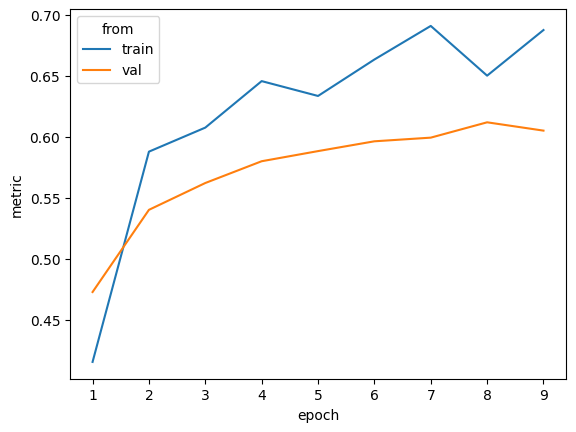

  0%|          | 0/400 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
for _ in range(15):
    clear_output(True)
    plot(acc_history, "accuracy")
    acc_history['train'].append(train(model, train_set, optimizer, scaler, scheduler, True, 0.9))
    acc_history['val'].append(validate(model, val_set, True))
clear_output(True)
plot(acc_history, "accuracy")

In [ ]:
torch.save(model.state_dict(), "./models/02_1_field.pt")

In [28]:
train(model, train_set, optimizer, scaler, scheduler)

validate(model, val_set)

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

{'f1': 0.6501755142749056,
 'precision': 0.6787277013744901,
 'recall': 0.644060880183413,
 'loss': 0.3369613107804131,
 'accuracy': 0.644060880183413}

In [ ]:
tokenizer.encode_plus("I'm here")

{'input_ids': [101, 1045, 1005, 1049, 2182, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer.get_vocab()

{'hampshire': 7035,
 'stroked': 11699,
 'persuasion': 27577,
 '##foil': 24323,
 'cartridge': 15110,
 'stumble': 21811,
 'dean': 4670,
 '##ize': 4697,
 'hindwings': 15998,
 '##65': 26187,
 'calming': 23674,
 '##cz': 27966,
 'maris': 23787,
 '##rangle': 21476,
 '##し': 30183,
 'doe': 18629,
 'chocolate': 7967,
 '##graph': 14413,
 'interceptions': 18387,
 'longevity': 26906,
 'kingsley': 22819,
 'cover': 3104,
 'nara': 27544,
 'reducing': 8161,
 '⟩': 1630,
 '##tung': 21847,
 'knocking': 10591,
 'clear': 3154,
 'announcer': 14073,
 '##mis': 15630,
 'romania': 6339,
 '##pc': 15042,
 'attach': 22476,
 'authoritarian': 27246,
 '##>': 29631,
 'affection': 12242,
 'favourites': 28271,
 'garden': 3871,
 'outstanding': 5151,
 '##一': 30266,
 'rudolf': 12794,
 'learners': 26262,
 '##tees': 28313,
 'computational': 15078,
 '##ruck': 29314,
 'coupe': 15130,
 '疒': 1913,
 'physician': 7522,
 'occur': 5258,
 'barr': 19820,
 'unwanted': 18162,
 'ric': 26220,
 '46th': 27990,
 'soaking': 22721,
 'erupted': 

In [ ]:
toks = tokenizer("Hi, I'm steve", max_length=MAX_LENGTH_SUMM, truncation=True, return_attention_mask=True,
    return_token_type_ids=False, return_tensors='np')

In [ ]:
feed = dict(
    input_ids=np.array(toks["input_ids"]).astype("int64"),
  attention_mask=np.array(toks["attention_mask"]).astype("int64"),
)

In [15]:
model.save_pretrained("./models/02_local-pt-checkpoint")
tokenizer.save_pretrained("./models/02_local-pt-checkpoint")

('./models/02_local-pt-checkpoint/tokenizer_config.json',
 './models/02_local-pt-checkpoint/special_tokens_map.json',
 './models/02_local-pt-checkpoint/vocab.txt',
 './models/02_local-pt-checkpoint/added_tokens.json',
 './models/02_local-pt-checkpoint/tokenizer.json')